## Imports and Functions

In [ ]:
"CELL - 01"
import json
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,roc_auc_score,roc_curve

file_name = 'nvdcve-1.0-2018.json'
json_data=open(file_name).read()
data = json.loads(json_data)

In [ ]:
"CELL - 02"

def print_keys(data, space = ''):
    """Prints a nested JSON.
    Print a nested JSON file recursively 
    Args:
        data : JSON type
        space : has an internal function, do not modify.
    """
    try:
        for key in data.keys():
            text = '{space}[\'{key}\']'.format(space=space, key=key)
            print text
            print_keys(data[key], space = text)
    except:
        return False

def parse_time_readable(time):
    b = parse(time)
    return str(b.day)+'/'+str(b.month)+'/'+str(b.year)

def url_check(data, url_to_check = 'www.exploit-db.com'):
    check_sum = 0
    for reference in data:
         check_sum += 1 if url_to_check in reference['url'] else 0
    if check_sum > 0:
        return 1
    return 0 

In [ ]:
"CELL - 03"


In [61]:
"CELL - 04"

print_keys(data)

['CVE_data_timestamp']
['CVE_data_version']
['CVE_Items']
['CVE_data_format']
['CVE_data_numberOfCVEs']
['CVE_data_type']


In [62]:
"CELL - 05"
pd.DataFrame(data)[:1]

,CVE_Items,CVE_data_format,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_data_type,CVE_data_version
0,{u'impact': {u'baseMetricV3': {u'cvssV3': {u'v...,MITRE,11830,2018-12-09T08:00Z,CVE,4.0


In [ ]:
"CELL - 06"
"""
Prints the nested structure of data['CVE_Items'] recoursively. 
"""
print_keys(data['CVE_Items'][0])

In [ ]:
"CELL - 07"
data['CVE_Items'][0]['cve']['problemtype']['problemtype_data'][0]['description'][0][]

In [ ]:
"CELL - 08"
"""
Parsing JSON file with desired fields.

Exception handling applied per field.
By this way none of the rows are ommitted. 

"""
cve_df = pd.DataFrame(columns=('ID', 'description', 'publishedDate','lastModifiedDate',
                             'cvssV2_baseScore','cvssV2_exploitabilityScore','cvssV2_impactScore',
                             'number_of_refs','exploit_db_flag'))

num_rows_to_get = len(data['CVE_Items'])

for idx in range(num_rows_to_get):
    try:
        id = data['CVE_Items'][idx]['cve']['CVE_data_meta']['ID']
    except:
        break
        
    try:
        description = data['CVE_Items'][idx]['cve']['description']['description_data'][0]['value']
    except:
        description = None

    try:    
        published_date = data['CVE_Items'][idx]['publishedDate']
    except:
        published_date= None

    try:    
        last_modified_date = data['CVE_Items'][idx]['lastModifiedDate']
    except:
        last_modified_date = None

    try:
        cvssV2_baseScore = data['CVE_Items'][idx]['impact']['baseMetricV2']['cvssV2']['baseScore']
    except:
        cvssV2_baseScore = None

    try:        
        cvssV2_exploitability_score = data['CVE_Items'][idx]['impact']['baseMetricV2']['exploitabilityScore']
    except:
        cvssV2_exploitability_score = None

    try:
        cvssV2_impactScore = data['CVE_Items'][idx]['impact']['baseMetricV2']['impactScore']
    except:
        cvssV2_impactScore = None

    try:
        number_of_refs = len(data['CVE_Items'][idx]['cve']['references']['reference_data'])
        exploit_db_flag = url_check(data['CVE_Items'][idx]['cve']['references']['reference_data'])
    except:
        number_of_refs = None

    cve_df.loc[idx] = [id,
                       description,
                       parse_time_readable(published_date), 
                       parse_time_readable(last_modified_date),
                       cvssV2_baseScore,
                       cvssV2_exploitability_score,
                       cvssV2_impactScore,
                       number_of_refs,
                       exploit_db_flag]
cve_df['number_of_refs'] = cve_df['number_of_refs'].astype(int)
cve_df['exploit_db_flag'] = cve_df['exploit_db_flag'].astype(int)

print 'DataFrame has {rows} rows and {unique_values} unique IDs.'.format(rows = cve_df['ID'].nunique(),
                                                                    unique_values = cve_df.shape[0])

In [53]:
"CELL - 09"
"""
Dateframe looks correct
"""
cve_df.head()

,ID,description,publishedDate,lastModifiedDate,cvssV2_baseScore,cvssV2_exploitabilityScore,cvssV2_impactScore,number_of_refs,exploit_db_flag
0,CVE-2018-0001,"A remote, unauthenticated attacker may be able...",10/1/2018,23/2/2018,7.5,10.0,6.4,3,0
1,CVE-2018-0002,On SRX Series and MX Series devices with a Ser...,10/1/2018,15/2/2018,4.3,8.6,2.9,2,0
2,CVE-2018-0003,A specially crafted MPLS packet received or pr...,10/1/2018,25/10/2018,6.1,6.5,6.9,3,0
3,CVE-2018-0004,A sustained sequence of different types of nor...,10/1/2018,6/2/2018,7.1,8.6,6.9,2,0
4,CVE-2018-0005,QFX and EX Series switches configured to drop ...,10/1/2018,2/2/2018,5.8,6.5,6.4,2,0


## Insights
In this section some basic insights are extracted from the data.

In [100]:
"CELL - 10"
cve_df.publishedDate.nunique(),cve_df.lastModifiedDate.nunique(),

(327, 298)

In [54]:
"CELL - 11"
cve_df.corr()

,cvssV2_baseScore,cvssV2_exploitabilityScore,cvssV2_impactScore,number_of_refs,exploit_db_flag
cvssV2_baseScore,1.000000,0.284792,0.856446,-0.009724,0.052477
cvssV2_exploitabilityScore,0.284792,1.000000,-0.250665,-0.073339,0.001985
cvssV2_impactScore,0.856446,-0.250665,1.000000,0.030016,0.051090
number_of_refs,-0.009724,-0.073339,0.030016,1.000000,0.092097
exploit_db_flag,0.052477,0.001985,0.051090,0.092097,1.000000


Text(0,0.5,u'cvssV2_baseScore')

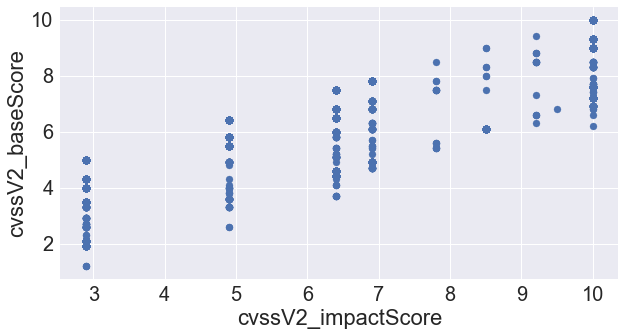

In [55]:
"CELL - 12"
x = 'cvssV2_impactScore'
y = 'cvssV2_baseScore'
fig = plt.figure(figsize=[10,5])
ax = fig.subplots(nrows=1, ncols=1)
ax.scatter(cve_df[x],cve_df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)

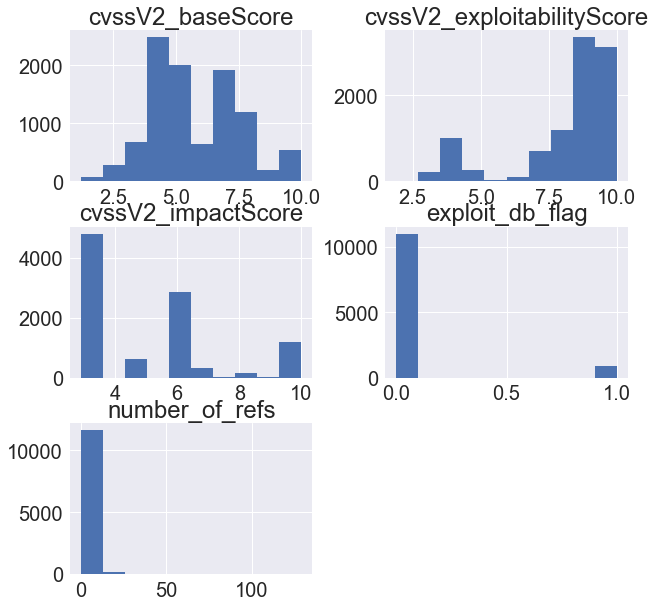

In [56]:
"CELL - 13"
%matplotlib inline
_ = cve_df.hist(figsize=[10,10])

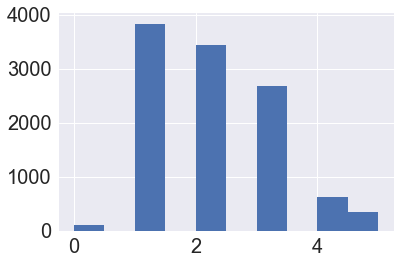

In [57]:
"CELL - 14"
%matplotlib inline

cve_df[cve_df.number_of_refs < np.quantile(cve_df.number_of_refs,0.95)].number_of_refs.hist()

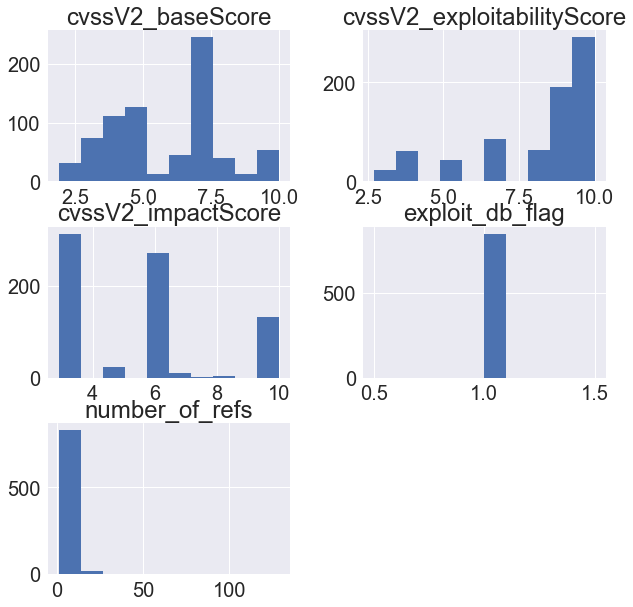

In [58]:
"CELL - 15"
%matplotlib inline
_ = cve_df[cve_df.exploit_db_flag==1].hist(figsize=[10,10])

## Topic Modeling

In this section, to analyze the description field we will run [Latent Dirichlet Allocation [LDA]](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). LDA is an unsupervised, machine learning algorithm agorithm. "if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model"

In [ ]:
"CELL - 16"


In [ ]:
"CELL - 17"
def remove_digits(x):    
    desc = x.description
    return ''.join([i for i in desc if not i.isdigit()])

In [106]:
"CELL - 18"
"""
LDA Class

All the Topic modeling related constructors and functions.
Since this is a un-supervised model there is no need to split Train and Test.
Topic modeling can be used in two main ways:
1-) Visulize the main themes/topics of the given texts.
2-) Use topic weights as an input to another ML model. This option can be thouth as
dimentionality reduction. Other option would be use bag-of-words which would be very expensive.
"""
class LDA:
    def __init__(self, documents, no_features = 1000, num_topics = 10):
        self.documents = documents
        self.no_features = no_features
        self.num_topics = num_topics
        self.tf = None
        self.tf_feature_names = None
        
    def _run_vectorizer(self):
        tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                max_features=self.no_features, 
                                stop_words='english')
        self.tf = tf_vectorizer.fit_transform(self.documents)
        self.tf_feature_names = tf_vectorizer.get_feature_names()
        
    
    def train(self):
        self._run_vectorizer()
        self.model = LatentDirichletAllocation(n_components = self.num_topics,
                                max_iter = 5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
        return self.model.fit_transform(self.tf)
    
    def print_all_topics(self,num_top_words=10):
        """
        Prints the top n words for each topic.
        
        Args:
            num_top_words : number of top n words to print.
        """
        for idx,topic in enumerate(self.model.components_):
            topic_words = ''
            for word in np.array(self.tf_feature_names)[topic.argsort()[-num_top_words:][::-1]]:
                topic_words = topic_words+' '+word
            print 'Topic {topic_num} : {topic_words}'.format(topic_num = idx,
                                                             topic_words = topic_words)
            
    def get_topic(self, topic_num, num_top_words=10, display = False):
        """
        Returns the selected topic with top n words.
        
        Args:
            topic_num : topic id to print.
            num_top_words : number of top n words.
            display : boolean flag. If true this function prints the 
                selected topic with top n words.
        """
        topic = self.model.components_[topic_num]
        topic_words = ''
        for word in np.array(self.tf_feature_names)[topic.argsort()[-num_top_words:][::-1]]:
            topic_words = topic_words+' '+word
        if display:    
            print 'Topic {topic_num} : {topic_words}'.format(topic_num = topic_num,
                                                             topic_words = topic_words)
        return topic_words

In [105]:
"CELL - 19"
"""
LDA splits the text corpus in to predetermined topics. 
Each topic is a collection of words. 
num_topics is the number of topic LDA will split the document corpus. 

Prints the Topics
"""

num_topics = 10

sub_df = cve_df.copy()
documents = sub_df.apply(remove_digits,axis=1)
lda = LDA(documents,
          no_features = 1000,
          num_topics = num_topics)
topic_array = lda.train()

sub_df['topic_id'] = np.argmax(topic_array, axis=1)
sub_df['topic_confidence'] = np.max(topic_array, axis=1)

lda.print_all_topics(num_top_words=10)

Topic 0 :  accessible vulnerability successful confidentiality integrity base affected update management attacker
Topic 1 :  php allows parameter xss admin contract arbitrary injection function user
Topic 2 :  cvss oracle vulnerability access data unauthorized attacks score java ac
Topic 3 :  android user information allows ibm access users id file files
Topic 4 :  service denial affected cause attacker vulnerability device software local allow
Topic 5 :  versions prior issue android kernel os discovered firefox linux msm
Topic 6 :  windows server earlier vulnerability information exploitation disclosure lead privilege bounds
Topic 7 :  cve microsoft vulnerability aka memory code affects exists remote execution
Topic 8 :  vulnerability code file remote buffer attackers allows crafted execute arbitrary
Topic 9 :  vulnerability attacker web allow site user remote cross arbitrary scripting


In [107]:
"CELL - 20"
"""
Print the topic order
"""
sub_df.groupby('topic_id').count()[['ID']].sort_values('ID',ascending=False)#.plot.bar(figsize=(15,5))

,ID
topic_id,
8,2401
1,2285
3,2010
9,1606
4,866
5,825
2,724
6,630
7,433


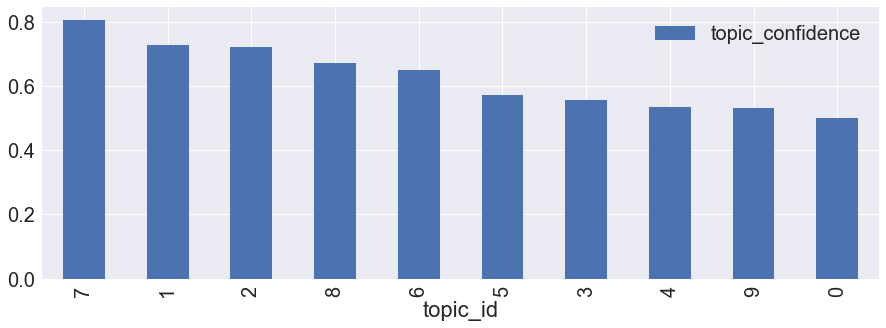

In [108]:
"CELL - 21"
sub_df.groupby('topic_id').median()[['topic_confidence']].sort_values('topic_confidence',
                                                                      ascending=False).plot.bar(figsize=(15,5))

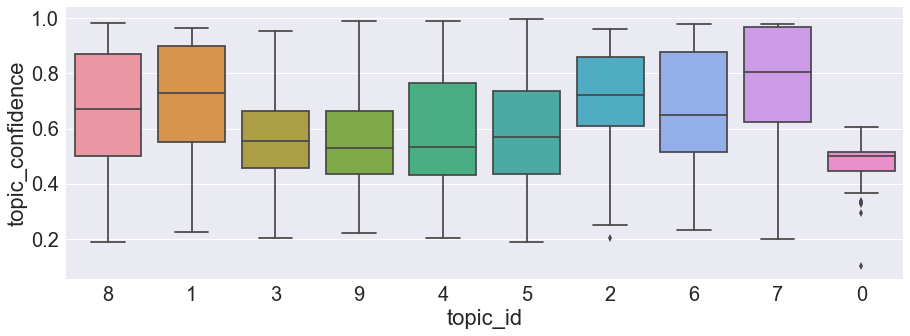

In [110]:
"CELL - 22"
columns_my_order = sub_df.groupby('topic_id').count()[['ID']].sort_values('ID',ascending=False).index.values

p1 = sns.boxplot(x='topic_id', y='topic_confidence', data=sub_df, order=columns_my_order)
sns.set(rc={'figure.figsize':(15,5)})
sns.set(font_scale=2)


In [ ]:
"CELL - 23"
sub_df[sub_df.topic_id==8][['topic_confidence','description']].sort_values('topic_confidence',
                                                                      ascending=False)[:20]

In [ ]:
"CELL - 24"
columns=['ID','topic_0','topic_1','topic_2','topic_3','topic_4','topic_5',
         'topic_6','topic_7','topic_8','topic_9']

lr_df.loc[11779][columns]

# Logistic Regression

In [67]:
"CELL - 25"
lr_df = pd.concat([sub_df, pd.DataFrame(topic_array, columns=['topic_0','topic_1','topic_2',
                                                      'topic_3','topic_4','topic_5',
                                                      'topic_6','topic_7','topic_8',
                                                      'topic_9'])], axis=1)

In [68]:
"CELL - 26"


In [69]:
"CELL - 27"
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0,
                        fit_intercept=True, intercept_scaling=1,
                        class_weight=None, random_state=None)

In [70]:
"CELL - 28"
def normalize(data, cap=None):
    """
    Caps (optional) and Normalizes an array of data.
    
    Args:
        data : numpy array.
        cap : float between 0 and 1. Caps the data with that given percentile value.
              Ex: if .95 is given, the maximum value is capped with 95th percentile.
        Normalization applied after capping the data. 
    """
    if cap:
        max_val = np.quantile(data, cap)
        capped = lr_df.number_of_refs.clip(0,max_val)
    else:
        max_val = data.max()
        capped = data
    return capped / max_val


lr_df['number_of_refs_capped_norm'] = normalize(lr_df['number_of_refs'], cap=.95)
lr_df['cvssV2_baseScore_norm'] = normalize(lr_df['cvssV2_baseScore'])
lr_df['cvssV2_exploitabilityScore_norm'] = normalize(lr_df['cvssV2_exploitabilityScore'])
lr_df['cvssV2_impactScore_norm'] = normalize(lr_df['cvssV2_impactScore'])

In [72]:
"CELL - 29"
columns_all = ['topic_0','topic_1','topic_2',
               'topic_3','topic_4','topic_5',
               'topic_6','topic_7','topic_8',
               'topic_9','cvssV2_baseScore_norm',
               'cvssV2_exploitabilityScore_norm',
               'cvssV2_impactScore_norm']

columns_notopic = ['cvssV2_baseScore_norm',
                   'cvssV2_exploitabilityScore_norm',
                   'cvssV2_impactScore_norm']

train = lr_df.sample(frac=0.8, random_state=200)
test = lr_df.drop(train.index)

def run_lr(train, test, model, columns, display=False):
    X_train = train.fillna(0)[columns]
    y_train = train['exploit_db_flag']

    X_test = test.fillna(0)[columns]
    y_test = test['exploit_db_flag']

    lr.fit(X_train, y_train)
    train_preds = lr.predict_proba(X_train)[:,1]
    test_preds = lr.predict_proba(X_test)[:,1]
    if display:
        print 'Train AUC : {train_auc} | Test AUC : {test_auc}'.format(
            train_auc = roc_auc_score(y_train, train_preds),
            test_auc=roc_auc_score(y_test, test_preds))
    return train_preds, test_preds

train_preds_all, test_preds_all = run_lr(train,test,lr,columns_all,display=True)
train_preds_notopic, test_preds_notopic = run_lr(train,test,lr,columns_notopic,display=True)


Train AUC : 0.685823252736 | Test AUC : 0.673818366158
Train AUC : 0.561093036385 | Test AUC : 0.567983856512


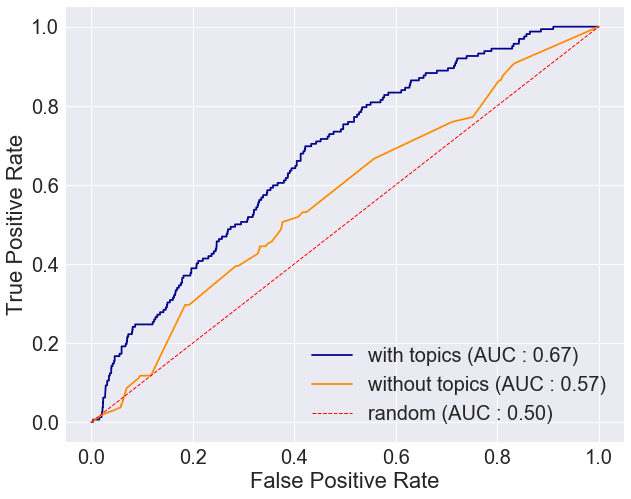

In [99]:
"CELL - 30"
fpr, tpr, _ = roc_curve(test['exploit_db_flag'], test_preds_all)
plt.plot(fpr, tpr,color='darkblue',
         label='with topics (AUC : %.2f)'%roc_auc_score(test['exploit_db_flag'],
                                                        test_preds_all))

fpr, tpr, _ = roc_curve(test['exploit_db_flag'], test_preds_notopic)
plt.plot(fpr, tpr, color='darkorange',
         label='without topics (AUC : %.2f)'%roc_auc_score(test['exploit_db_flag'],
                                                           test_preds_notopic))
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--',label='random (AUC : 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.set(rc={'figure.figsize':(10,8)},font_scale=2)
plt.legend()